In [4]:
from VR_Trajectory_analysis import *

In [5]:
directory = '/Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData'

In [6]:
df = get_combined_df(directory, trim_seconds=1.0)

Processing subfolder: 20250312_155324
Processing subfolder: 20250311_165653
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Choice_noBG_VR4_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Forrest_choice_VR4_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Forrest_choice_VR2_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Choice_noBG_VR2_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Choice_noBG_VR3_.csv
No data loaded from /Users/apaula/ownCloud/MatrexVR1/20250226_BlueGreenBlue_Geometry_Data/RunData/20250311_165653/20250311_165653_Forrest_choice_VR3_.csv
Processin

In [7]:
df["FlyID"].nunique()

63

In [8]:
df = add_trial_id_and_displacement(df)
df = add_trial_time(df)

In [9]:
df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_displacement(df[df['Scene']=='Choice_noBG'], min_disp=0, max_disp=500)

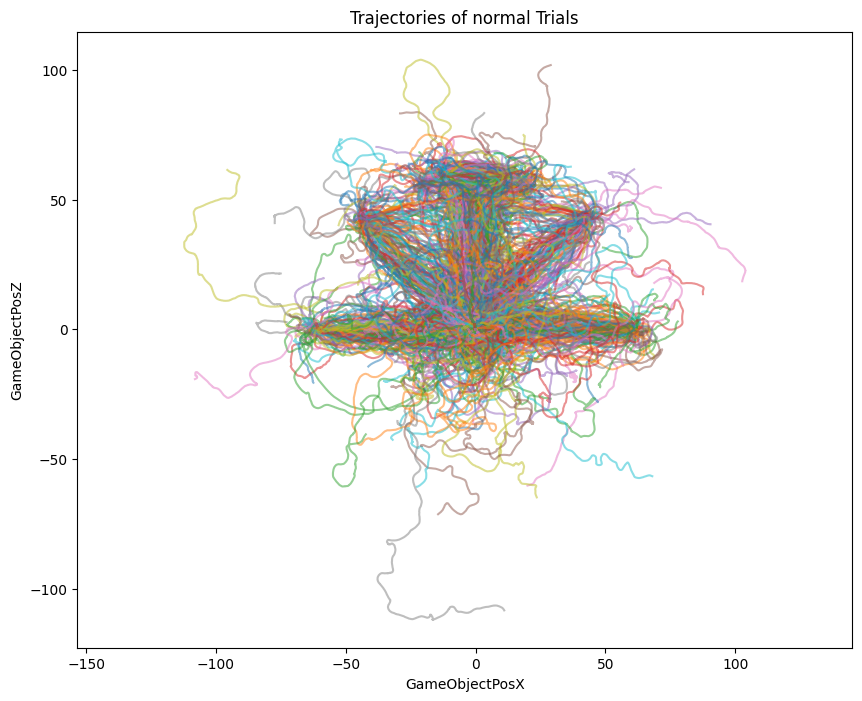

In [10]:
plot_trajectories(df_normal, 'normal')

In [11]:
import pandas as pd
import numpy as np

# 1. Define your different config groups and their corresponding goals
#    (You can rename these lists and add/remove as needed.)
configs_2_goals_front = [
    "BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json",
    "BinaryChoice_constantSize_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_BlueCylinder_BlueGreenCylinder.json"
]

# For these configs, the left and right goals are at:
# (-10.416, 59.088) and (10.416, 59.088).
# Adjust threshold or other parameters as needed.
left_goal_1 = (-10.416, 59.088)
right_goal_1 = (10.416, 59.088)

# If you have other configs that use 2 goals with a different positioning:
configs_2_goals_side = [
    "BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json",
    "BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json"
]
left_goal_2 = (-60, 0)
right_goal_2 = (60, 0)

configs_2_goals_diag = [
    "BinaryChoice_constantSize_90deg_BlueCylinder_BlueGreenCylinder.json",
    "BinaryChoice_constantSize_90deg_BlueGreenCylinder_BlueCylinder.json"
]
left_goal_3 = (-42.43, 42.43)
right_goal_3 = (42.43, 42.43)

# For 3-goal configs:
configs_3_goals = [
    "3Cylinders111_constantSize.json"
]
triple_center_goal = (0, 60)
triple_left_goal = (-20.5212, 56.381557)
triple_right_goal = (20.5212, 56.381557)

# For single-goal configs (if needed):
configs_center_only = [
]
center_goal = (0, 60)


# 2. Subset your df_normal by each group and call get_first_goal_reached
def get_first_goal_reached(
    df_normal,
    goals,            # A list of (goal_name, (x, z)) tuples
    threshold=3.5
):
    """
    Given a dataframe of trial data, determine the first goal reached 
    and the time at which it was reached for each UniqueTrialID.
    
    Parameters
    ----------
    df_normal : pd.DataFrame
        The dataframe containing trial data. Must contain columns:
        ['UniqueTrialID', 'ConfigFile', 'trial_time', 'GameObjectPosX', 'GameObjectPosZ'].
    goals : list of (str, (float, float))
        A list of (goal_name, (x, z)) to check.
    threshold : float, optional
        Distance threshold below which a goal is considered reached.

    Returns
    -------
    pd.DataFrame
        A dataframe with one row per UniqueTrialID, including:
        ['UniqueTrialID', 'ConfigFile', 'FirstReachedGoal', 'GoalReachedTime'].
    """
    
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    results = []
    
    # Group by UniqueTrialID
    for trial_id, trial_data in df_normal.groupby('UniqueTrialID'):
        config = trial_data['ConfigFile'].iloc[0]
        
        # Sort by time
        trial_data = trial_data.sort_values(by='trial_time')
        
        first_reached = None
        reached_time = None
        
        for idx, row in trial_data.iterrows():
            participant_pos = (row['GameObjectPosX'], row['GameObjectPosZ'])
            
            # Check each goal
            for goal_name, goal_pos in goals:
                if distance(participant_pos, goal_pos) <= threshold:
                    first_reached = goal_name
                    reached_time = row['trial_time']
                    break
            
            if first_reached is not None:
                break
        
        results.append((trial_id, config, first_reached, reached_time))
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=[
        'UniqueTrialID',
        'ConfigFile',
        'FirstReachedGoal',
        'GoalReachedTime'
    ])
    
    return results_df


# 3. Filter and run for each group, then concatenate

# --- Group 1: 2 goals (front) ---
df_2_goals_front = df_normal[df_normal['ConfigFile'].isin(configs_2_goals_front)].copy()
results_2_goals_front = get_first_goal_reached(
    df_2_goals_front,
    goals=[
        ('left', left_goal_1),
        ('right', right_goal_1)
    ],
    threshold=3.5
)

# --- Group 2: 2 goals (left=-60,0 ; right=60,0) ---
df_2_goals_side = df_normal[df_normal['ConfigFile'].isin(configs_2_goals_side)].copy()
results_2_goals_side = get_first_goal_reached(
    df_2_goals_side,
    goals=[
        ('left', left_goal_2),
        ('right', right_goal_2)
    ],
    threshold=3.5
)

# --- Group 3: 2 goals (diagonal) ---
df_2_goals_diag = df_normal[df_normal['ConfigFile'].isin(configs_2_goals_diag)].copy()
results_2_goals_diag = get_first_goal_reached(
    df_2_goals_diag,
    goals=[
        ('left', left_goal_3),
        ('right', right_goal_3)
    ],
    threshold=3.5
)

# --- Group 4: 3 goals ---
df_3_goals = df_normal[df_normal['ConfigFile'].isin(configs_3_goals)].copy()
results_3_goals = get_first_goal_reached(
    df_3_goals,
    goals=[
        ('triple_center', triple_center_goal),
        ('triple_left', triple_left_goal),
        ('triple_right', triple_right_goal)
    ],
    threshold=3.5
)

# --- Group 5: single center goal (if needed) ---
df_center_only = df_normal[df_normal['ConfigFile'].isin(configs_center_only)].copy()
results_center_only = get_first_goal_reached(
    df_center_only,
    goals=[('center', center_goal)],
    threshold=3.5
)

# 4. Concatenate all results
all_results = pd.concat([
    results_2_goals_front,
    results_2_goals_side,
    results_2_goals_diag,
    results_3_goals,
    results_center_only
], ignore_index=True)

# all_results now contains the first reached goal for each UniqueTrialID
# from each different config group.


/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_11358/83303377.py:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([


In [12]:
df['ConfigFile'].unique()

array(['BinaryChoice_constantSize_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json',
       'BinaryChoice_constantSize_BlueCylinder_BlueGreenCylinder.json',
       '3Cylinders111_constantSize.json',
       'BinaryChoice_constantSize_90deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_90deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json',
       'Treecircle.json'], dtype=object)

In [13]:
all_results.to_pickle("geometry2_results_df.pkl")

In [14]:
results_df = pd.read_pickle("geometry2_results_df.pkl")

In [15]:
results_df['FirstReachedGoal'].unique()

array([None, 'left', 'right', 'triple_left', 'triple_center',
       'triple_right'], dtype=object)

In [16]:
# 1. Keep only trials that actually reached a goal
valid_results = results_df.dropna(subset=['FirstReachedGoal'])

# 2. Merge the cutoff times back into df
#    We merge on 'UniqueTrialID' to get each trial's GoalReachedTime.
df_merged = pd.merge(df, valid_results[['UniqueTrialID', 'GoalReachedTime', 'FirstReachedGoal']], on='UniqueTrialID', how='inner')

# 3. Filter df so that only rows with trial_time less than or equal to the goal time are kept
df_cut = df_merged[df_merged['trial_time'] <= df_merged['GoalReachedTime']]

In [22]:
# Save DataFrames as pickle (binary, preserves dtypes & indexes)
df_cut_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry2/df_cut.pkl'
results_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry2/results_df.pkl'
df_cut.to_pickle(df_cut_path_pickle)
results_df.to_pickle(results_df_path_pickle)

In [ ]:
from VR_Trajectory_analysis import *
df_cut_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry2/df_cut.pkl'
results_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry2/results_df.pkl'
df_cut = pd.read_pickle(df_cut_path_pickle)
results_df = pd.read_pickle(results_df_path_pickle)

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_11358/106928492.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


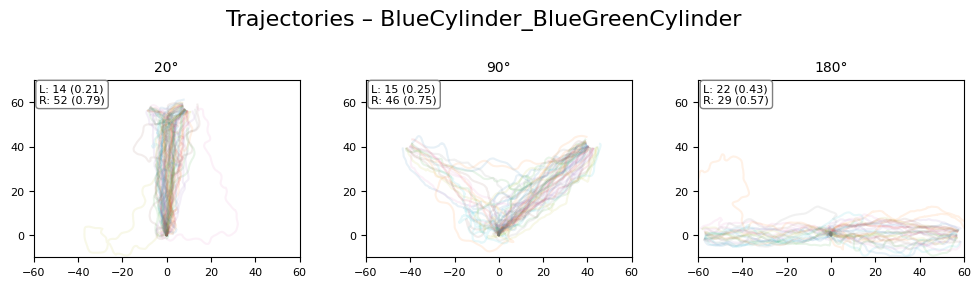

In [24]:
# -----------------------------------------------------------------
#  Trajectories for all  "BlueCylinder_BlueGreenCylinder" configs
#  shown in a grid, sorted by angle
# -----------------------------------------------------------------
import os, math, re
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

# 1.  Merge once so goal info sits beside positions  (if not done already)
df_joined = pd.merge(
    df_cut,
    results_df[['UniqueTrialID', 'FirstReachedGoal']],
    on='UniqueTrialID',
    how='left'
)

# 2.  Collect the configs of interest & extract angle ──────────────────
angle_pat = re.compile(r'(\d+)(?:deg|°)')

def angle_from_name(cfg: str):
    # explicit mapping for constant-size files (treated as 20°)
    if "constantSize_BlueCylinder_BlueGreenCylinder" in cfg:
        return 20
    if "constantSize_BlueGreenCylinder_BlueCylinder" in cfg:
        return 20
    
    # drop the all-black-cylinder variant
    if "BlackCylinder_BlackCylinder" in cfg:
        return None
    
    # default: pull the number in “…_130deg…” / “…_130°.json”
    m = angle_pat.search(cfg)
    return float(m.group(1)) if m else None


records = []
for cfg in df_joined['ConfigFile'].unique():
    if "BlueCylinder_BlueGreenCylinder" not in cfg:
        continue
    ang = angle_from_name(cfg)
    if ang is None:
        print(f"⚠️  angle missing → skipped: {cfg}")
        continue
    records.append((ang, cfg))

if not records:
    raise ValueError("No matching BlueCylinder_BlueGreenCylinder configs found.")

records.sort(key=lambda t: t[0])   # numeric angle order

# 3. Build grid  (unchanged) ───────────────────────────────────────────
n_cfg, n_cols = len(records), 3
n_rows = math.ceil(n_cfg / n_cols)
fig   = plt.figure(figsize=(n_cols*4, n_rows*3.75))
gs    = gridspec.GridSpec(n_rows, n_cols, wspace=.25, hspace=.35)

# 4. One subplot per config  (identical to before) ─────────────────────
for idx, (angle, cfg) in enumerate(records):
    ax  = fig.add_subplot(gs[idx])
    g   = df_joined[df_joined['ConfigFile'] == cfg]

    for _, td in g.groupby('UniqueTrialID'):
        ax.plot(td['GameObjectPosX'], td['GameObjectPosZ'], alpha=.1)

    ax.set_xlim(-40, 40);  ax.set_ylim(-10, 70);  ax.set_aspect('equal')
    ax.set_xticks([-60,-40,-20,0,20,40,60]);  ax.set_yticks([0,20,40,60])
    ax.tick_params(labelsize=8)
    ax.set_title(f"{int(angle)}°", fontsize=10)

    res   = results_df.loc[results_df['UniqueTrialID'].isin(g['UniqueTrialID'])]
    left  = (res['FirstReachedGoal']=='left').sum()
    right = (res['FirstReachedGoal']=='right').sum()
    tot   = left+right
    txt   = f"L: {left} ({left/tot:.2f})\nR: {right} ({right/tot:.2f})" if tot else "no goals"
    ax.text(.02,.98,txt,transform=ax.transAxes,va='top',fontsize=8,
            bbox=dict(boxstyle="round",fc="w",ec=".5"))

for j in range(idx+1,n_rows*n_cols):
    fig.add_subplot(gs[j]).axis('off')

fig.suptitle("Trajectories – BlueCylinder_BlueGreenCylinder", y=.92, fontsize=16)
plt.tight_layout()
plt.show()

⚠️  angle not found → skipped: BinaryChoice11_constantSize_BlackCylinder_BlackCylinder.json


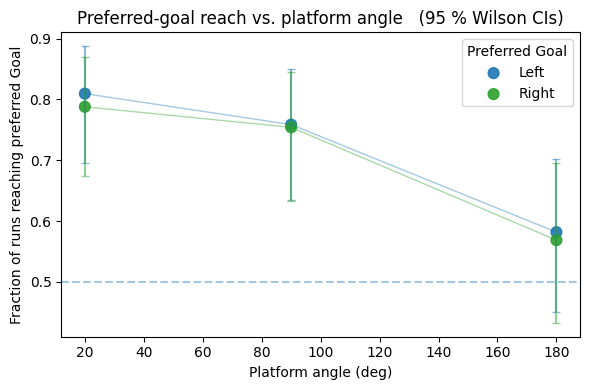

In [21]:
# ------------------------------------------------------------
# Preferred-goal reach vs platform angle      (all two-goal configs)
# ------------------------------------------------------------
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint   # pip install statsmodels

#––– 1.  Merge once so we have the goal info in the movement dataframe –––#
df_joined = pd.merge(
    df_cut,
    results_df[['UniqueTrialID', 'FirstReachedGoal']],
    on='UniqueTrialID',
    how='left'
)

#––––– 2.  Per-config goal counts + Wilson CIs ––––––––––––––––––––––#
angle_pat   = re.compile(r'(\d+)[°d]')        # catches “…_30deg…” or “…_30°.json”

def get_angle(cfg: str):
    """
    Return the numeric platform angle encoded in a config-file name.
    • "BinaryChoice_constantSize_BlueCylinder_BlueGreenCylinder.json"  → 20
    • "BinaryChoice_constantSize_BlueGreenCylinder_BlueCylinder.json"  → 20
    • "…_110deg.json" → 110
    • anything that does not match → None
    """
    # 1️⃣  explicit mapping for the 'constantSize' files
    if "constantSize_BlueCylinder_BlueGreenCylinder" in cfg:
        return 20.0
    if "constantSize_BlueGreenCylinder_BlueCylinder" in cfg:
        return 20.0
    
    # 2️⃣  skip the BlackCylinder_BlackCylinder config altogether
    if "BlackCylinder_BlackCylinder" in cfg:
        return None
    
    # 3️⃣  otherwise fall back to the regex
    m = angle_pat.search(cfg)
    if m:
        return float(m.group(1))
    return None


records = []

for cfg, g in df_joined.groupby('ConfigFile'):
    
    # keep the early-exit for single-goal configs
    if 'center_only_configs' in globals() and cfg in center_only_configs:
        continue
    
    # left / right counts
    res    = results_df.loc[results_df['UniqueTrialID'].isin(g['UniqueTrialID'])]
    left   = (res['FirstReachedGoal'] == 'left').sum()
    right  = (res['FirstReachedGoal'] == 'right').sum()
    n      = left + right
    if n == 0:
        continue
    
    # angle lookup
    angle = get_angle(cfg)
    if angle is None:                # skip if still unresolved
        print(f"⚠️  angle not found → skipped: {cfg}")
        continue
    
    # Wilson CI on left-goal proportion
    p_left       = left / n
    ci_lo, ci_hi = proportion_confint(left, n, alpha=.05, method='wilson')
    
    # colour / label (unchanged)
    if   "BlueGreenCylinder_BlueCylinder" in cfg:
        colour, label = 'tab:blue',  'BG→B'
    elif "BlueCylinder_BlueGreenCylinder" in cfg:
        colour, label = 'tab:green', 'B→BG'
    else:
        colour, label = 'tab:orange','other'
    
    records.append(dict(
        ConfigFile=cfg,
        angle=angle,
        p_left=p_left, lo_left=ci_lo, hi_left=ci_hi,
        colour=colour, label=label,
        n_trials=n, left_cnt=left, right_cnt=right
    ))


df = pd.DataFrame(records)
df['angle'] = pd.to_numeric(df['angle'])     # <- guarantees float dtype

#––– 3.  Flip B→BG rows so p = fraction reaching their *preferred* goal –––#
flip        = df['label'] == 'B→BG'          # rows to invert
orig_lo     = df.loc[flip, 'lo_left'].values
orig_hi     = df.loc[flip, 'hi_left'].values
orig_p      = df.loc[flip, 'p_left'].values

df.loc[flip, 'p_left']  = 1 - orig_p
df.loc[flip, 'lo_left'] = 1 - orig_hi
df.loc[flip, 'hi_left'] = 1 - orig_lo
df.rename(columns=dict(
    p_left='p_pref', lo_left='lo_pref', hi_left='hi_pref'
), inplace=True)

#––– 4.  Plot ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# --- preferred legend text ----------------------------------
label_map = {
    'BG→B': 'Left',        # BlueGreenCylinder_BlueCylinder
    'B→BG': 'Right',       # BlueCylinder_BlueGreenCylinder
    'other': 'Symmetric'
}

plt.figure(figsize=(6, 4))

for lbl, grp in df.groupby('label'):
    plt.scatter(grp['angle'], grp['p_pref'],
                c=grp['colour'],
                label=label_map[lbl],          # ← mapped text here
                s=60, alpha=.9)

    col = grp['colour'].iloc[0]

    grp = grp.sort_values('angle', key=lambda s: s.astype(float))

    # connecting line
    plt.plot(grp['angle'], grp['p_pref'],
             c=grp['colour'].iloc[0], lw=1, alpha=.4)

    plt.errorbar(grp['angle'], grp['p_pref'],
                 yerr=[grp['p_pref']-grp['lo_pref'],
                       grp['hi_pref']-grp['p_pref']],
                 fmt='none', ecolor=col, alpha=.5, capsize=3)

plt.axhline(.5, ls='--', alpha=.4)
plt.xlabel('Platform angle (deg)')
plt.ylabel('Fraction of runs reaching preferred Goal')
plt.title('Preferred-goal reach vs. platform angle   (95 % Wilson CIs)')

plt.legend(title='Preferred Goal')             # ← new legend title
plt.tight_layout()
plt.show()


In [27]:
df_cut_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry3/df_cut.pkl'
results_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry3/results_df.pkl'
df_cut_3 = pd.read_pickle(df_cut_path_pickle)
results_df_3 = pd.read_pickle(results_df_path_pickle)

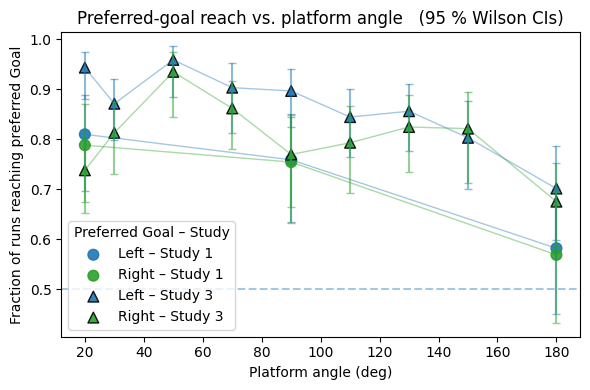

In [29]:
import re, pandas as pd, matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# ---------- helper ----------------------------------------------------
angle_pat = re.compile(r'(\d+)[°d]')

def platform_angle(cfg: str):
    if "constantSize_BlueCylinder_BlueGreenCylinder" in cfg:  return 20
    if "constantSize_BlueGreenCylinder_BlueCylinder" in cfg:  return 20
    if "BlackCylinder_BlackCylinder" in cfg:                  return None
    m = angle_pat.search(cfg)
    return float(m.group(1)) if m else None

def one_study(df_cut, results_df, study_tag):
    """Return a DataFrame with one row per config for a single study."""
    joined = df_cut.merge(results_df[['UniqueTrialID','FirstReachedGoal']],
                          on='UniqueTrialID', how='left')

    rows = []
    for cfg, g in joined.groupby('ConfigFile'):
        if 'center_only_configs' in globals() and cfg in center_only_configs:
            continue

        res   = results_df.loc[results_df['UniqueTrialID'].isin(g['UniqueTrialID'])]
        left  = (res['FirstReachedGoal']=='left').sum()
        right = (res['FirstReachedGoal']=='right').sum()
        n     = left+right
        if n == 0:   continue

        ang = platform_angle(cfg)
        if ang is None:   continue

        p_left       = left/n
        lo, hi       = proportion_confint(left, n, .05, 'wilson')

        if   "BlueGreenCylinder_BlueCylinder" in cfg:   colour, label = 'tab:blue',  'BG→B'
        elif "BlueCylinder_BlueGreenCylinder" in cfg:   colour, label = 'tab:green', 'B→BG'
        else:                                          colour, label = 'tab:orange','other'

        rows.append(dict(study=study_tag, angle=ang,
                         p_left=p_left, lo=lo, hi=hi,
                         colour=colour, label=label))
    return pd.DataFrame(rows)

# ---------- collect both studies -------------------------------------
df1 = one_study(df_cut,  results_df,   'Study 1')
df3 = one_study(df_cut_3, results_df_3, 'Study 3')
df  = pd.concat([df1, df3], ignore_index=True)

# flip the right-preferred configs
flip = df['label'] == 'B→BG'
df.loc[flip, ['p_left','lo','hi']] = 1 - df.loc[flip, ['p_left','hi','lo']].values
df.rename(columns={'p_left':'p_pref', 'lo':'lo_pref', 'hi':'hi_pref'}, inplace=True)

# ---------- plot ------------------------------------------------------
marker_map = {'Study 1':  'o',   # solid circle
              'Study 3': '^'}    # triangle

plt.figure(figsize=(6,4))
label_map = {'BG→B':'Left', 'B→BG':'Right', 'other':'Symmetric'}

for (study,lbl), grp in df.groupby(['study','label']):
    grp = grp.sort_values('angle')
    plt.scatter(grp['angle'], grp['p_pref'],
                c=grp['colour'], marker=marker_map[study],
                edgecolor='k' if study=='Study 3' else None,
                s=60, alpha=.9,
                label=f"{label_map[lbl]} – {study}")
    plt.plot(grp['angle'], grp['p_pref'],
             c=grp['colour'].iloc[0], lw=1, alpha=.4)

    plt.errorbar(grp['angle'], grp['p_pref'],
                 yerr=[grp['p_pref']-grp['lo_pref'],
                       grp['hi_pref']-grp['p_pref']],
                 fmt='none', ecolor=grp['colour'].iloc[0],
                 alpha=.5, capsize=3)

plt.axhline(.5, ls='--', alpha=.4)
plt.xlabel('Platform angle (deg)')
plt.ylabel('Fraction of runs reaching preferred Goal')
plt.title('Preferred-goal reach vs. platform angle   (95 % Wilson CIs)')
plt.legend(title='Preferred Goal – Study')
plt.tight_layout()
plt.show()


In [51]:
df_cut.columns

Index(['Current Time', 'VR', 'Scene', 'CurrentSequenceScene', 'ConfigFile',
       'CurrentTrial', 'CurrentStep', 'GameObjectPosX', 'GameObjectPosY',
       'GameObjectPosZ', 'GameObjectRotX', 'GameObjectRotY', 'GameObjectRotZ',
       'SensPosX', 'SensPosY', 'SensPosZ', 'SensRotX', 'SensRotY', 'SensRotZ',
       'SourceFile', 'elapsed_time', 'ExperimenterName', 'Comments', 'FlyID',
       'UniqueTrialID', 'delta_x', 'delta_y', 'delta_z', 'step_distance',
       'TotalDisplacement', 'trial_time', 'GoalReachedTime',
       'FirstReachedGoal', 'Colony'],
      dtype='object')

In [52]:
# ------------------------------------------------------------------
# Build a lookup table: UniqueTrialID  →  FlyID  →  Colony
# Each UniqueTrialID appears many times in df_cut, so .drop_duplicates().
# ------------------------------------------------------------------
trial2fly = (
    df_cut[['UniqueTrialID', 'FlyID']]
      .drop_duplicates()
      .assign(Colony=lambda d: d['FlyID'].str[0])   # first char = colony
)

# Merge that onto results_df (and do the same for the _3 study)
results_df   = results_df.merge(trial2fly, on='UniqueTrialID', how='left')
results_df_3 = results_df_3.merge(trial2fly, on='UniqueTrialID', how='left')


In [53]:
results_df.columns
# ['UniqueTrialID', 'ConfigFile', 'FirstReachedGoal', 'GoalReachedTime',
#  'FlyID', 'Colony']


Index(['UniqueTrialID', 'ConfigFile', 'FirstReachedGoal', 'GoalReachedTime',
       'FlyID', 'Colony'],
      dtype='object')

In [54]:
from statsmodels.stats.proportion import proportion_confint

def colony_counts(rdf):
    tbl = (rdf['FirstReachedGoal']
              .where(rdf['FirstReachedGoal'].isin(['left','right']))
              .groupby(rdf['Colony'])
              .value_counts()
              .unstack(fill_value=0))
    tbl['total']  = tbl.sum(1)
    tbl['p_left'] = tbl['left'] / tbl['total']
    lo, hi        = proportion_confint(tbl['left'], tbl['total'],
                                       alpha=.05, method='wilson')
    tbl['lo95'], tbl['hi95'] = lo, hi
    return tbl

sum1 = colony_counts(results_df)
sum3 = colony_counts(results_df_3)

display(sum1)
display(sum3)


FirstReachedGoal,left,right,total,p_left,lo95,hi95
Colony,,,,,,
0,3,3,6,0.500000,0.187616,0.812384
1,53,36,89,0.595506,0.491642,0.691466
2,28,27,55,0.509091,0.380763,0.636232
3,137,146,283,0.484099,0.426478,0.542146
4,0,1,1,0.000000,0.000000,0.793451


FirstReachedGoal,left,right,total,p_left,lo95,hi95
Colony,,,,,,
1,0,1,1,0.000000,0.000000,0.793451
3,15,11,26,0.576923,0.389486,0.744556
4,0,1,1,0.000000,0.000000,0.793451


In [1]:
import pandas as pd, matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as st

# ---------------- 1.  add a Colony column to the *trial* tables ----------------
for rdf in (results_df, results_df_3):
    rdf['Colony'] = rdf['FlyID'].str[0]      # first char of FlyID

# ---------------- 2.  per-colony left/right counts (one row = one trial) -------
def colony_counts(rdf):
    """Return DataFrame with left/right counts and Wilson CI per colony."""
    tbl = (rdf['FirstReachedGoal']
           .where(rdf['FirstReachedGoal'].isin(['left', 'right']))  # ignore centre / NaN
           .groupby(rdf['Colony'])
           .value_counts()
           .unstack(fill_value=0))

    tbl['total']  = tbl.sum(1)
    tbl['p_left'] = tbl['left'] / tbl['total']
    lo, hi = proportion_confint(tbl['left'], tbl['total'], method='wilson')
    tbl['lo_95'], tbl['hi_95'] = lo, hi
    return tbl

sum1 = colony_counts(results_df).assign(study='Study 1')
sum3 = colony_counts(results_df_3).assign(study='Study 3')

print("Study 1\n", sum1, "\n")
print("Study 3\n", sum3, "\n")

# ---------------- 3.  χ² test of independence (pooled studies) -----------------
pooled = sum1[['left','right']] + sum3[['left','right']]
chi2, p, dof, exp = st.chi2_contingency(pooled, correction=False)
print(f"Chi² test (left vs right across colonies, pooled studies): "
      f"χ²={chi2:.2f}, dof={dof}, p={p:.4g}")

# ---------------- 4.  visual comparison ----------------------------------------
fig, ax = plt.subplots(figsize=(6,4))

def draw(tbl, colour, offset, label):
    x   = tbl.index.astype(int) + offset
    p   = tbl['p_left']
    ax.errorbar(x, p,
                yerr=[p - tbl['lo_95'], tbl['hi_95'] - p],
                fmt='o', color=colour, capsize=4, label=label)

draw(sum1, 'tab:blue',  -0.1, 'Study 1')
draw(sum3, 'tab:orange', 0.1, 'Study 3')

ax.axhline(.5, ls='--', c='k', alpha=.4)
ax.set_xlabel('Colony ID')
ax.set_ylabel('Proportion of trials reaching *left* goal')
ax.set_title('Left-goal choice by colony (Wilson 95 % CI)')
ax.set_xticks(sorted(set(sum1.index.astype(int)) | set(sum3.index.astype(int))))
ax.legend()
fig.tight_layout()
plt.show()


NameError: name 'results_df' is not defined

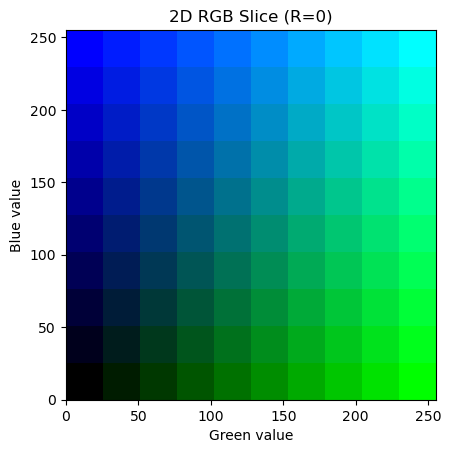

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of steps in each dimension (green, blue)
n_steps = 10  # change to 9 if you really only want 9 steps

# Create evenly spaced integer values from 0 to 255
values = np.linspace(0, 255, n_steps, dtype=int)

# Initialize an empty array for the 2D color grid
# Shape: (n_steps, n_steps, 3) for RGB channels
color_grid = np.zeros((n_steps, n_steps, 3), dtype=float)

# Fill the grid
# i will index blue, j will index green
for i, blue in enumerate(values):
    for j, green in enumerate(values):
        # Red channel = 0, green and blue scaled to [0,1] for matplotlib
        color_grid[i, j] = [0, green / 255.0, blue / 255.0]

plt.imshow(
    color_grid,
    origin='lower',       # so that the [0,0] index is at the bottom left
    extent=(0, 255, 0, 255)  # x-axis from 0 to 255 (green), y-axis from 0 to 255 (blue)
)
plt.xlabel("Green value")
plt.ylabel("Blue value")
plt.title("2D RGB Slice (R=0)")
plt.show()


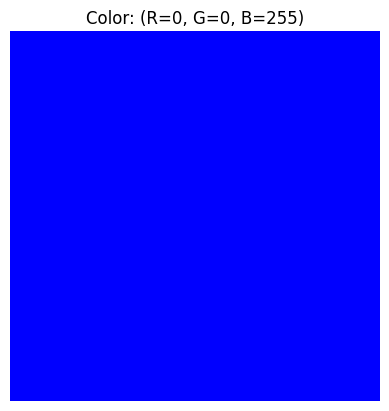

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the color [R=0, G=127, B=127]
color = [0, 0, 255]

# Create a small array (e.g., 50x50) filled with that color
height, width = 50, 50
color_array = np.zeros((height, width, 3), dtype=np.uint8)
color_array[:, :] = color  # Fill every pixel with (0,127,127)

# Display the color array
plt.imshow(color_array)
plt.axis('off')  # Hide axes if you want just the color
plt.title(f"Color: (R={color[0]}, G={color[1]}, B={color[2]})")
plt.show()
